# DBSCAN

[Curso de Clustering con Python y scikit-learn](https://platzi.com/cursos/clustering)

##1)-Library Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

##2)-Data preparation

In [2]:
X, y, c = make_blobs(500, cluster_std=0.8, centers=4, n_features=2,return_centers=True)

df_blobs = pd.DataFrame(
    {
        'x1': X[:,0],
        'x2': X[:,1]
    }
)

df_centers = pd.DataFrame(
    {
        'x1': c[:,0],
        'x2': c[:,1],
    }
)


In [3]:
X_m ,y_m = make_moons(n_samples=250, noise=0.05, random_state=42)

df_moons = pd.DataFrame(
    {
        'x1': X_m[:,0],
        'x2': X_m[:,1]
    }
    )

##2)-Data Visualization

First we visualize the blobs-points

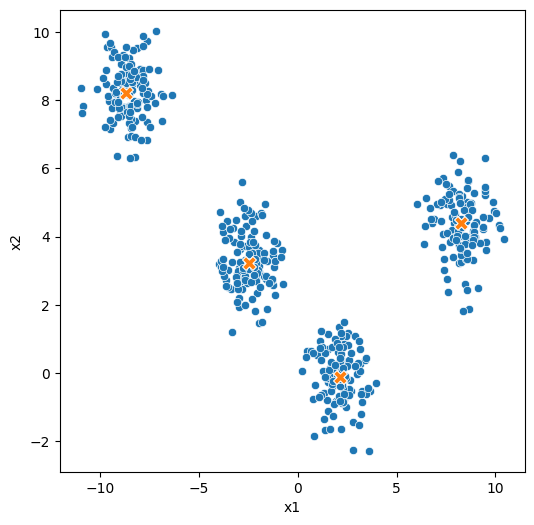

In [4]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(data=df_blobs, x='x1', y='x2')
sns.scatterplot(data=df_centers, x='x1', y='x2', marker='X', s = 100)
plt.plot()
plt.show()

Now, we visualize the sandomly generated moons.

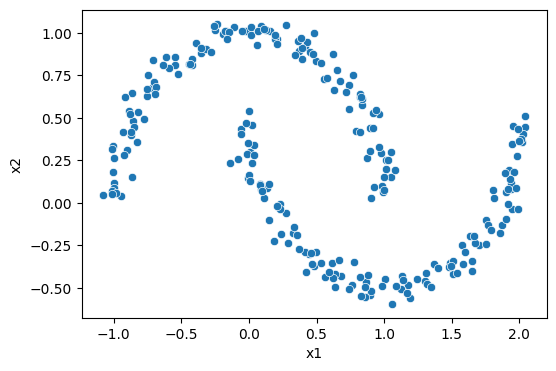

In [7]:
fig = plt.figure(figsize=(6,4))
sns.scatterplot(data=df_moons, x='x1',y='x2')
plt.show()

Here as the moons are not spherical data, we cannot just use k-means, even more, Hierachical Clustering could have poor performance.

##3)-Implementing DBSCAN

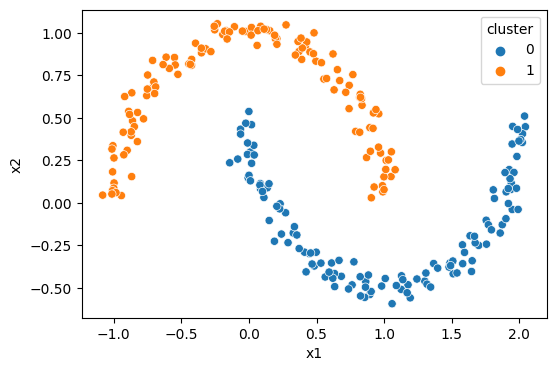

In [14]:
dbscan_cluster = DBSCAN(eps=0.3, min_samples=3)
y_m_predict = dbscan_cluster.fit_predict(X_m)
df_moons['cluster'] = y_m_predict
fig = plt.figure(figsize=(6,4))
sns.scatterplot(data=df_moons, x='x1',y='x2', hue='cluster')
plt.show()

Now, we solve the clustering problem for the blob data.

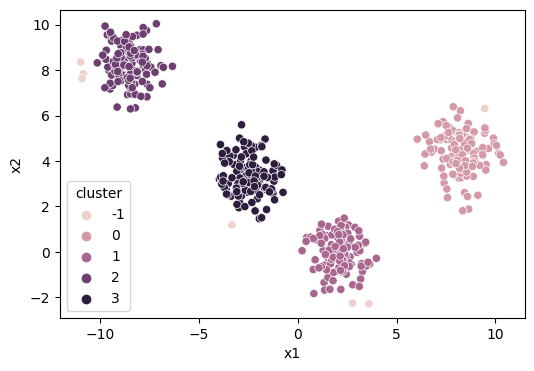

In [19]:
dbscan = DBSCAN(eps=0.7, min_samples=4)
y_predict = dbscan.fit_predict(X)
df_blobs['cluster'] = y_predict 

fig = plt.figure(figsize=(6,4))
sns.scatterplot(data=df_blobs, x='x1', y='x2',hue='cluster')
plt.plot()
plt.show()


Note that DBSCAN classify as noise those points that are far away from the central cluster by assignin them the cluster value "-1".

##4)-Hyperparameters

Now, we must find the optimal values for the hyperparameters. To this end we first calculate an estimate of the data centroid radious epsilon using the "Knee method", which uses first the K-Nearest neighbours algorithm to plot the distance of a point with respecto to the other data set as a function of the nearest neighbour distance. The idea is to obtain a persfpective of the distance to the nearest neighbours that maximizes the first nearest neighbour distance within the knee of the nearest-distance plot.

In [20]:
from sklearn.neighbors import NearestNeighbors

In [24]:
neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

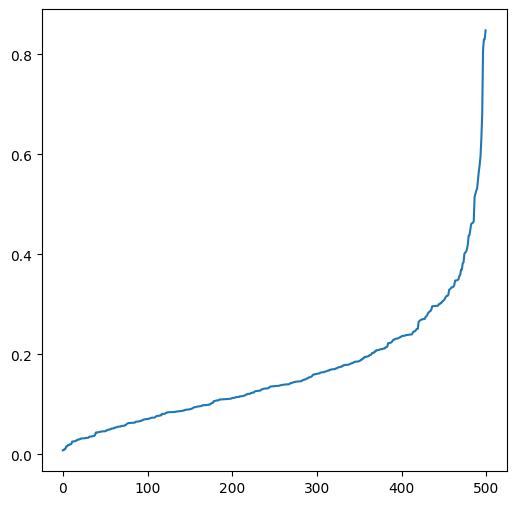

In [25]:
distances = np.sort(distances,axis=0)
distances = distances[:,1]

fig = plt.figure(figsize=(6,6))
plt.plot(distances)
plt.show()

According to the nearest distance graph, the optimal value could be:

In [38]:
eps_values = np.arange(0.25, 0.6, 0.10) 
min_samples = np.arange(2,10)

We have estimated some possible values for the radious epsilon such that they lies whin the knee, then, we create a ist o posible minumum of neigbours.

The product function is used to generate all possible combinations of eps_values and min_samples. These combinations are stored in the dbscan_paramns list, where each element is a tuple representing a combination of eps and min_samples values.

In [27]:
from itertools import product

In [39]:
dbscan_paramns = list(product(eps_values,min_samples))
sil_scores = []

for p in dbscan_paramns: 
    y_pred = DBSCAN(eps= p[0], min_samples=p[1]).fit_predict(X)
    sil_scores.append(silhouette_score(X,y_pred))


In [40]:
df_paramns_tunning = pd.DataFrame.from_records(dbscan_paramns, columns = ['Eps','Min_Samples'])
df_paramns_tunning['sil_scores'] = sil_scores
df_paramns_tunning.head()

,Eps,Min_Samples,sil_scores
0,0.25,2,-0.017402
1,0.25,3,-0.058805
2,0.25,4,-0.036352
3,0.25,5,-0.185397
4,0.25,6,-0.247475


We generate a pivot-table to better understand the results of all posible combinations for the number of samples and the epsilon radious.

In [41]:
pivot_data = pd.pivot_table(df_paramns_tunning, values='sil_scores',index='Min_Samples',columns='Eps')                
pivot_data.head()

Eps,0.25,0.35,0.45,0.55
Min_Samples,,,,
2,-0.017402,0.096345,0.315177,0.455731
3,-0.058805,0.165695,0.448736,0.491635
4,-0.036352,0.237740,0.434445,0.716093
5,-0.185397,0.217046,0.522927,0.699697
6,-0.247475,0.085675,0.487851,0.684392


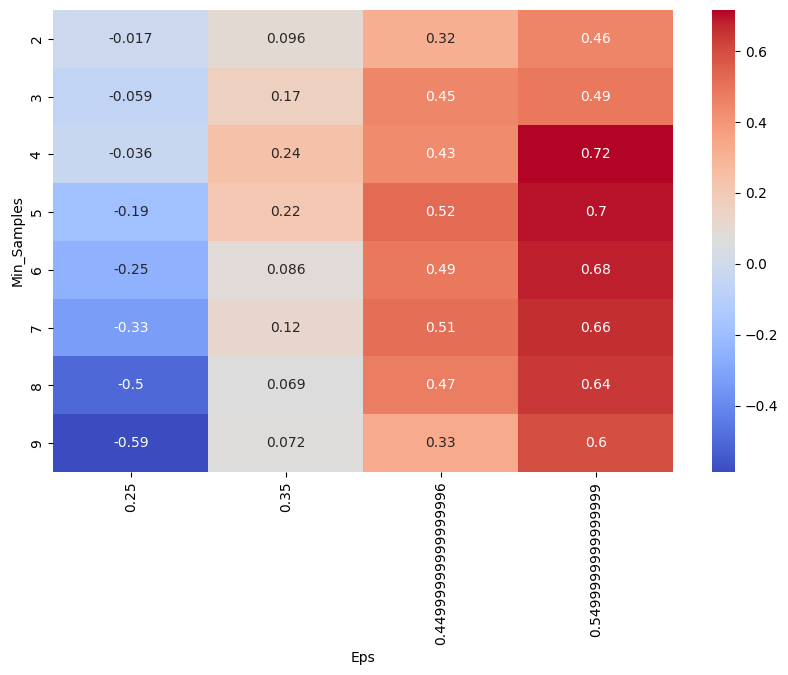

In [42]:
fig, ax  = plt.subplots(figsize =(10,6))
sns.heatmap(pivot_data, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax = ax)
plt.show()

##5)-DBSCAN Evaluation

Once we have obtained the best hyperparameter values as the tuple with the highest silhouete score, we proceed to evaluate our model por these values.

In [43]:
dbscan_cluster = DBSCAN(eps=0.54, min_samples=4)
y_predict = dbscan_cluster.fit_predict(X)
df_blobs['cluster'] = y_predict

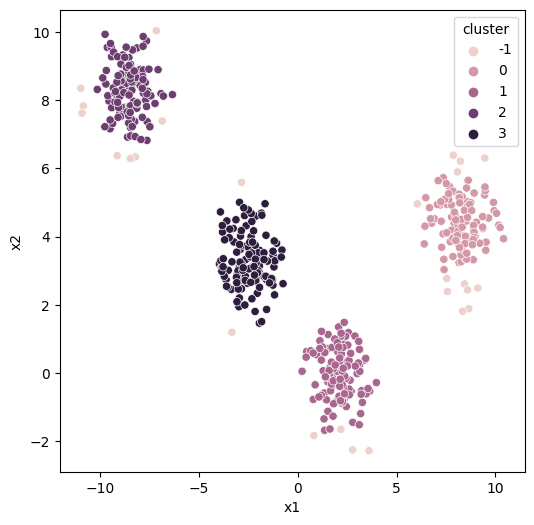

In [45]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(data=df_blobs, x='x1', y='x2',hue='cluster')
plt.plot()
plt.show()

We can see that visually, the algorithm correctly performs a 4-cluster classification together with the noise classification. Nevertheless we can formally check the silhouete score and determine with the help of a graph if this solution is optimal.

For n_clusters = 5 The average silhouette_score is : 0.713161041612256


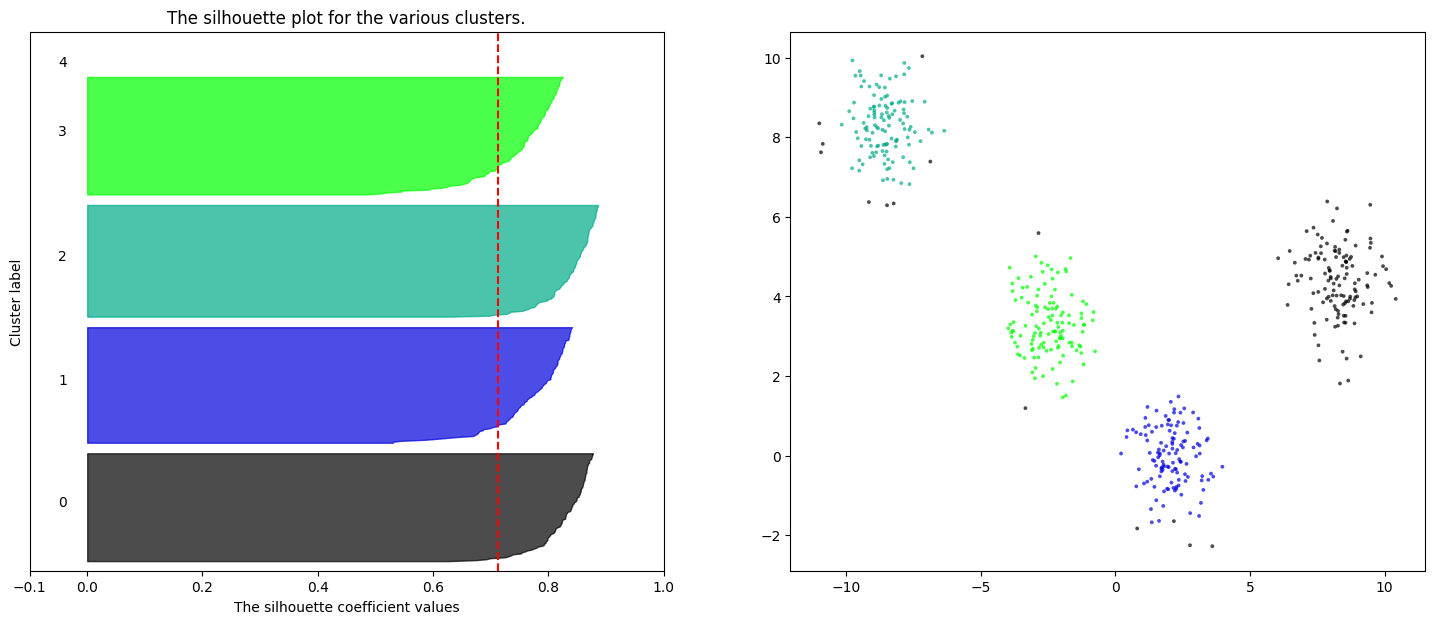

In [46]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np



# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.

clusterer = DBSCAN(eps=0.54, min_samples=4)
cluster_labels = clusterer.fit_predict(X)
n_clusters = len(np.unique(cluster_labels))

ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)
y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)


plt.show()